In [65]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('bright')
from Energy_Levels import MoleculeLevels
from Energy_Levels import branching_ratios, Calculate_TDMs,Calculate_TDM_evecs
from functools import partial
np.set_printoptions(precision=5, suppress=True)
from tabulate import tabulate
from matplotlib.collections import LineCollection

In [66]:
%matplotlib inline

In [67]:
import copy

def select_dipole(dipole,TDM_func):
    if dipole == 'z':
        TDM = TDM_func(0)
    elif dipole == '+':
        TDM = TDM_func(1)
    elif dipole == '-':
        TDM = TDM_func(1)
    elif 'x' in dipole:
        TDMx = -1/np.sqrt(2)*(TDM_func(1)-TDM_func(-1))
        if dipole=='x':
            TDM=TDMx
        elif dipole=='x+z' or dipole=='z+x':
            TDM = 1/np.sqrt(2)*(abs(TDMx)+abs(TDM_func(0)))
    else:
        TDM = 1/np.sqrt(3)*(abs(TDM_func(-1))+abs(TDM_func(0))+abs(TDM_func(1)))
    return TDM

def lorentzian(f,f0,g,N):
    return N*(g/2)**2 /((f-f0)**2 + (g/2)**2)


def simulate_spectra(field_EB,state_g,state_e,g_idx,e_idx,ret_str =False,with_F=True,freq_array=None,diagonalize=False,T=4,origin = 0,P_adjust=False,square=True,pad=10,dipole='z',cm=True,thresh=1e-3,g=7.9/(29979.2458),dip=False,make_lorentzians=True,plot=True):
    E0, B0 = field_EB
    if diagonalize:
        G_evals,G_evecs = copy.deepcopy(state_g.eigensystem(E0,B0))
        E_evals,E_evecs = copy.deepcopy(state_e.eigensystem(E0,B0))
    else:
        G_evals,G_evecs = copy.deepcopy(state_g.evals0),copy.deepcopy(state_g.evecs0)
        E_evals,E_evecs = copy.deepcopy(state_e.evals0),copy.deepcopy(state_e.evecs0)
    TDM_func = partial(Calculate_TDMs,Ground=state_g,Excited=state_e,Ez=E0,Bz=B0,q=[-1,1])
    TDM_EB = select_dipole(dipole,TDM_func)
    if cm:
        E_evals/=29979.2458
        G_evals/=29979.2458
    E_evals+= origin
    dE_EB = np.subtract.outer(E_evals, G_evals)
    
    all_param = []
    flist = []
    TDMlist = []
    t_str_list = []
    for i in g_idx:
        vec_g = G_evecs[i,:]
        q_g = abs(vec_g).argmax()
        for j in e_idx:
            vec_e = E_evecs[j,:]
            q_e = abs(vec_e).argmax()
            Je,Me,Fe = [state_e.q_numbers[_q][q_e] for _q in ['J','M','F']]
            Pe = {1:'+',-1:'-'}[state_e.parities[j]]
            Ng,Jg,Mg,Fg = [state_g.q_numbers[_q][q_g] for _q in ['N','J','M','F']]
            Pg = {1:'+',-1:'-'}[state_g.parities[i]]
            if Me % 1 == 0:
                Me=int(Me)
                Mg = int(Mg)
#                 if N==1:
#                     boltz=1
#                 else:
#                     boltz = np.exp(-(0.352*(N*(N+1)-2)/T))
            if cm:
                boltz = np.exp(-G_evals[i]*1.439/T)
            else:
                boltz = np.exp(-4.799e-5*G_evals[i]/T)
            _TDM = TDM_EB[j,i]
            _dE = dE_EB[j,i]
            if _dE<0:
                continue
            if abs(_TDM) < thresh:
                continue
            flist.append(_dE)
            if square:
                _TDM = np.square(_TDM)
            _TDM*= boltz
            if Jg>Je and P_adjust:
                _TDM*=(2*Je+1)/(2*Jg+1)
            all_param.append([_dE,g,_TDM])
            TDMlist.append(_TDM)
            # with_F = True
            if ret_str:
                if with_F:
                    full_str = '(N={Ng}{Pg},J={Jg},F={Fg},M={Mg})->(J={Je}{Pe},F={Fe},M={Me})\nTDM={tdm}'.format(Je=Je,Fe=Fe,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Mg=Mg,Pg=Pg,tdm=_TDM)
                else:
                    dJ = Je-Jg
                    PQR_J = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dJ]
                    dJN = Jg - Ng
                    dN = (Je-0.5) - Ng
                    PQR_N = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dN]
                    F12 = {0.5:'1',-0.5:'2'}[dJN]
                    full_str = []
                    pqr_str = r'$^{{{pqr_n}}} {{{pqr_j}}}_{{1{{{fi}}}}}({{{Ng}}}^{{{{{Pg}}}}})$'.format(pqr_n=PQR_N,pqr_j=PQR_J,fi=F12,Ng=Ng,Pg=Pg)
                    full_str.append(pqr_str)
                    qn_str = ['{Ng}, {Jg2}/2'.format(Ng=Ng,Jg2=int(Jg*2)),'{Je2}/2'.format(Je2=int(Je*2))]
                    full_str.extend(qn_str)
                    freq_str = ['{}'.format(np.round(_dE,5))]
                    full_str.extend(freq_str)
#                     '\t' + r'$N={{{Ng}}}^{{{{{Pg}}}}},J={{{Jg}}},M={{{Mg}}} \rightarrow J={{{Je}}}^{{{{{Pe}}}}},M={{{Me}}}$'.format(Je=Je,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Mg=Mg,Pg=Pg)
                t_str_list.append(full_str)
    if flist==[]:
        flist.append(0)
        all_param.append([0,g,0])
        TDMlist.append(0)
    if make_lorentzians:
        if freq_array is None:
            fmin = min(flist)-pad*g
            fmax = max(flist)+pad*g
            n=int((fmax-fmin)/(g/20))
            freq = np.linspace(fmin,fmax,n)
        else:
            freq = freq_array
            n = len(freq_array)
        tot_lor = np.zeros(n)
        for param in all_param:
            tot_lor+=lorentzian(freq,*param)
        if dip:
            tot_lor*=-1
        if plot:
            plt.figure()
            plt.plot(freq,tot_lor)
        if ret_str:
            return flist,(freq,tot_lor),TDMlist,t_str_list
        else:
            return flist,(freq,tot_lor),TDMlist
    else:
        if ret_str:
            return flist,TDMlist,t_str_list
        else:
            return flist,TDMlist


def simulate_spectra_noM(field_EB,state_g,state_e,g_idx,e_idx,ret_str =False,with_F=True,freq_array=None,diagonalize=False,boltz_bool=True,T=4,origin = 0,P_adjust=False,pad=10,dipole='z',cm=True,thresh=1e-3,g=7.9/(29979.2458),dip=False,make_lorentzians=True,plot=True):
    E0, B0 = field_EB
    if diagonalize:
        G_evals,G_evecs = copy.deepcopy(state_g.eigensystem(E0,B0))
        E_evals,E_evecs = copy.deepcopy(state_e.eigensystem(E0,B0))
    else:
        G_evals,G_evecs = copy.deepcopy(state_g.evals0),copy.deepcopy(state_g.evecs0)
        E_evals,E_evecs = copy.deepcopy(state_e.evals0),copy.deepcopy(state_e.evecs0)
    BR_EB = branching_ratios(state_g,state_e,E0,B0).T
    if cm:
        E_evals/=29979.2458
        G_evals/=29979.2458
    E_evals+= origin
    dE_EB = np.subtract.outer(E_evals, G_evals)
    
    all_param = []
    flist = []
    BRlist = []
    t_str_list = []
    for i in g_idx:
        vec_g = G_evecs[i,:]
        q_g = abs(vec_g).argmax()
        for j in e_idx:
            vec_e = E_evecs[j,:]
            q_e = abs(vec_e).argmax()
            Je,Me,Fe = [state_e.q_numbers[_q][q_e] for _q in ['J','M','F']]
            Pe = {1:'+',-1:'-'}[state_e.parities[j]]
            Ng,Jg,Mg,Fg = [state_g.q_numbers[_q][q_g] for _q in ['N','J','M','F']]
            Pg = {1:'+',-1:'-'}[state_g.parities[i]]
            if Me % 1 == 0:
                Me=int(Me)
                Mg = int(Mg)
#                 if N==1:
#                     boltz=1
#                 else:
#                     boltz = np.exp(-(0.352*(N*(N+1)-2)/T))
            if cm:
                boltz = np.exp(-G_evals[i]*1.439/T)
            else:
                boltz = np.exp(-4.799e-5*G_evals[i]/T)
            _BR =BR_EB[j,i]
            _dE = dE_EB[j,i]
            if _dE<0:
                continue
            if abs(_BR) < thresh:
                continue
            flist.append(_dE)
            # if square:
            #     _TDM = np.square(_TDM)
            if boltz_bool:
                _BR*= boltz
            if Jg>Je and P_adjust:
                _BR*=(2*Je+1)/(2*Jg+1)
            all_param.append([_dE,g,_BR])
            BRlist.append(_BR)
            # with_F = True
            if ret_str:
                if with_F:
                    full_str = '(J={Jg},F={Fg})->(J={Je}{Pe},F={Fe})\nBR={br}'.format(Je=Je,Fe=Fe,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Pg=Pg,br=_BR)
                    # full_str = '(N={Ng}{Pg},J={Jg},F={Fg})->(J={Je}{Pe},F={Fe})\nBR={br}'.format(Je=Je,Fe=Fe,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Pg=Pg,br=_BR)
                else:
                    dJ = Je-Jg
                    PQR_J = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dJ]
                    dJN = Jg - Ng
                    dN = (Je-0.5) - Ng
                    PQR_N = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dN]
                    F12 = {0.5:'1',-0.5:'2'}[dJN]
                    full_str = []
                    pqr_str = r'$^{{{pqr_n}}} {{{pqr_j}}}_{{1{{{fi}}}}}({{{Ng}}}^{{{{{Pg}}}}})$'.format(pqr_n=PQR_N,pqr_j=PQR_J,fi=F12,Ng=Ng,Pg=Pg)
                    full_str.append(pqr_str)
                    qn_str = ['{Ng}, {Jg2}/2'.format(Ng=Ng,Jg2=int(Jg*2)),'{Je2}/2'.format(Je2=int(Je*2))]
                    full_str.extend(qn_str)
                    freq_str = ['{}'.format(np.round(_dE,5))]
                    full_str.extend(freq_str)
#                     '\t' + r'$N={{{Ng}}}^{{{{{Pg}}}}},J={{{Jg}}},M={{{Mg}}} \rightarrow J={{{Je}}}^{{{{{Pe}}}}},M={{{Me}}}$'.format(Je=Je,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Mg=Mg,Pg=Pg)
                t_str_list.append(full_str)
    if flist==[]:
        flist.append(0)
        all_param.append([0,g,0])
        BRlist.append(0)
    if make_lorentzians:
        if freq_array is None:
            fmin = min(flist)-pad*g
            fmax = max(flist)+pad*g
            n=int((fmax-fmin)/(g/20))
            freq = np.linspace(fmin,fmax,n)
        else:
            freq = freq_array
            n = len(freq_array)
        tot_lor = np.zeros(n)
        for param in all_param:
            tot_lor+=lorentzian(freq,*param)
        if dip:
            tot_lor*=-1
        if plot:
            plt.figure()
            plt.plot(freq,tot_lor)
        if ret_str:
            return flist,(freq,tot_lor),BRlist,t_str_list
        else:
            return flist,(freq,tot_lor),BRlist
    else:
        if ret_str:
            return flist,BRlist,t_str_list
        else:
            return flist,BRlist

In [68]:
N_g = np.arange(0,7)
N_e = np.arange(1,9)

In [69]:
g = MoleculeLevels.initialize_state('YbOH','174','X000',N_g,M_values = 'none',I=[0,1/2],S=1/2,round=8,P_values=[1/2])
e = MoleculeLevels.initialize_state('YbOH','174','A000',N_e,M_values = 'none',I=[0,1/2],S=1/2,round=8,P_values=[1/2])
g.eigensystem(0,1e-3);
e.eigensystem(0,1e-3);
# gidx = g.select_q({'N':[0,1,2,3,4,5,7,8,9,10,11]})
# eidx = e.select_q({'J':[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]})

Cannot construct decoupled basis without M values
Cannot construct decoupled basis without M values


In [70]:
g.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5755.56,
 'Gamma_SR': 175.38,
 'bF': 96.3,
 'c': 19,
 'muE': 1.96834092,
 'D': 0.004197094412}

In [71]:
e.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.471605811175,
 'ASO': 0.0,
 'h1/2': 0,
 'a': 9.5,
 'bF': 0,
 'c': 0,
 'd': 10,
 'p+2q': -12312.770346461299,
 'q': 0,
 'D': 0.004197094412,
 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 13284.618014811987}

In [72]:
c=29979.2458
Tv = lambda Te,v,we,wexe,weye: Te+we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3
E_X0=Tv(0,0,469.4052,1.8346,3.06e-3)
E_A0=Tv(11962.0524,0,437.9536,1.8714,0)
10**7*1/(E_A0-632.28175/2-E_X0) #origin in nm

859.8322052455535

In [73]:
new_g = {'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': (0.216529655-1.163568e-3*1/2)*c,
 'Gamma_SR': 2.69905e-3*c,
 'bF': 2.196510e-3*c,
 'c': 0.243647e-3*c,
 'muE': 1.96834092,
 'D': 1.84299e-7*c}
new_g

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 6473.9543046956915,
 'Gamma_SR': 80.91548337649,
 'bF': 65.849713192158,
 'c': 7.3043533014326,
 'muE': 1.96834092,
 'D': 0.0055251450216942}

In [74]:
new_e={'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': (0.21227-1.12e-3*1/2)*c,
 'ASO': 0*632.28175*c,
 'h1/2': 0*(0.8856e-3-1/2*-0.1848e-3)*c,
 'a': (0.8856e-3-1/2*-0.1848e-3)*c,
 'bF': 0,
 'c': 0,
 'd': -0.1194e-3*c,
 'p+2q': -0.257550*c,
 'q': 0,
 'D': 2e-7*c,
 # 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': E_A0-E_X0-632.28175/2}
new_e

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 6346.906128318,
 'ASO': 0.0,
 'h1/2': 0.0,
 'a': 29.319702392399996,
 'bF': 0,
 'c': 0,
 'd': -3.57952194852,
 'p+2q': -7721.15475579,
 'q': 0,
 'D': 0.0059958491599999995,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 11630.1761425}

In [75]:
g.update_params(new_g)
e.update_params(new_e)

Successfully converted eigenvectors from bBJ to aBJ


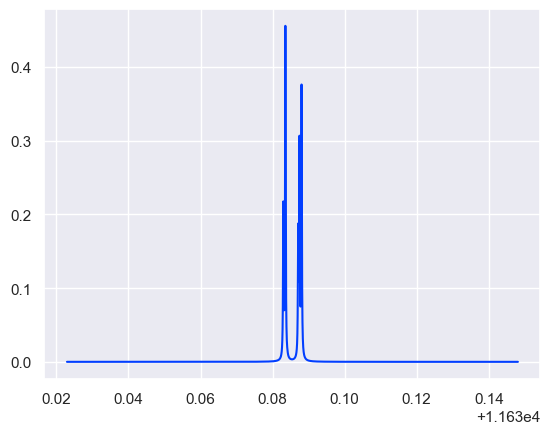

In [76]:
gidx = g.select_q({'N':1})
eidx = e.select_q({'J':0.5},parity='+')
flist,(freq,tot_lor),BRlist,t_str_list = simulate_spectra_noM([0,0],g,e,gidx,eidx,ret_str =True,freq_array=None,boltz_bool=True,diagonalize=False,T=2,origin = e.parameters['Origin'],P_adjust=False,pad=300,dipole='all',cm=True,thresh=1e-5,g=6/(29979.2458),dip=False,make_lorentzians=True,plot=True)

In [77]:
help(e.display_levels)

Help on method display_levels in module Energy_Levels:

display_levels(Ez, Bz, pattern_q, idx=None, label=True, label_off=0.03, parity=False, pretty=True, thickness=1.5, label_q=None, width=0.75, ket_size=10, label_size=14, figsize=(10, 10), ylim=None, deltaE_label=3000, alt_label=False) method of Energy_Levels.MoleculeLevels instance



In [81]:
eM = MoleculeLevels.initialize_state('YbOH','174','A000',[1,2,3],M_values = 'all',I=[0,1/2],S=1/2,round=8,P_values=[1/2])
# eM.update_params(new_e)

In [83]:
eM.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.471605811175,
 'ASO': 0.0,
 'h1/2': 0,
 'a': 9.5,
 'bF': 0,
 'c': 0,
 'd': 10,
 'p+2q': -12312.770346461299,
 'q': 0,
 'D': 0.004197094412,
 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 13284.618014811987}

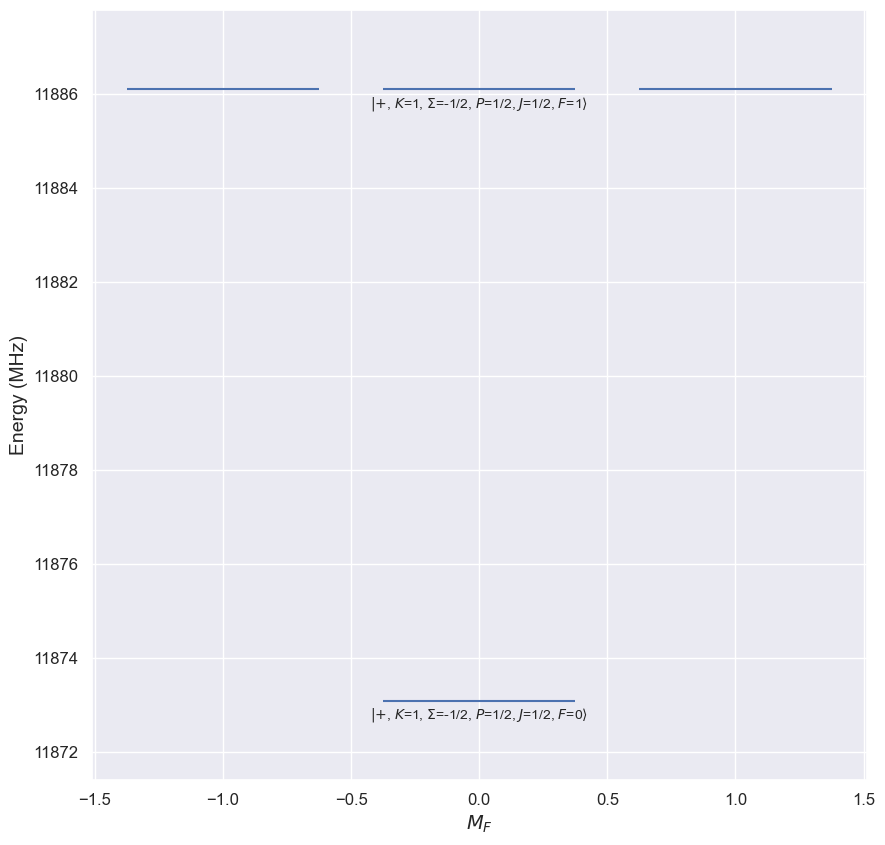

In [82]:
eM.display_levels(0,1e-3,'F',idx=eM.select_q({'J':0.5},parity='+'),parity=True)
plt.ticklabel_format(useOffset=False)

(-200.0, 200.0)

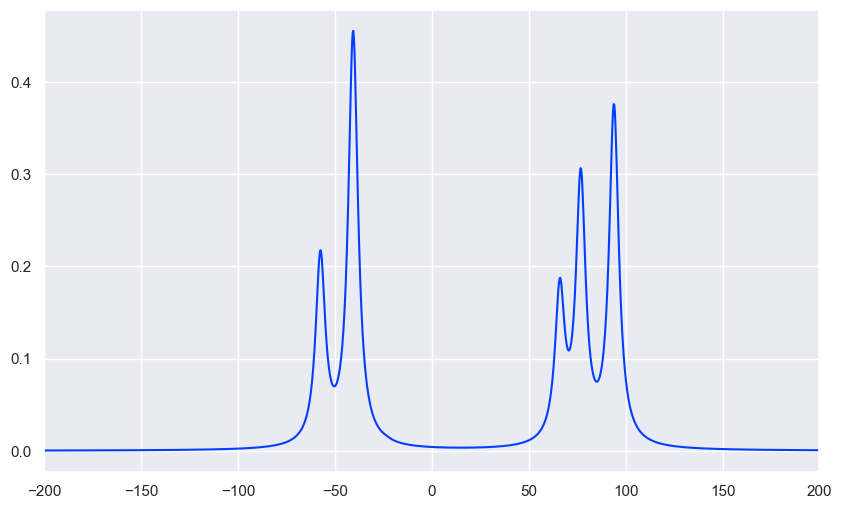

In [53]:
c=29979.2458
origin = e.parameters['Origin']
plt.figure(figsize=(10,6))
MHz = lambda x:c*(x-0*origin)
fMHz = MHz(freq) 
plt.plot(fMHz-348661174,tot_lor)
plt.xlim(-200,200)

In [24]:
for tstr,line in zip(t_str_list,flist):
    if 'J=0.5+,' in tstr:
        print(tstr)
        print(line*c-348661174+57.55402845,'\n')

(J=0.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.38675405976811245
134.37042134855957 

(J=0.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.4985588779175847
151.50166815375061 

(J=0.5,F=0.0)->(J=0.5+,F=1.0)
BR=0.22160304561488486
123.56448143576355 

(J=1.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.6132459420089822
16.88557493542404 

(J=1.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.0014411236654150914
34.01682174061508 

(J=1.5,F=2.0)->(J=0.5+,F=1.0)
BR=0.2783957589578057
-1.4427214978240954e-09 



0
(J=0.5,F=1.0)->(J=0.5+,F=0.0)
11630.087465922605 

1
(J=0.5,F=1.0)->(J=0.5+,F=1.0)
11630.088037359488 

2
(J=0.5,F=0.0)->(J=0.5+,F=1.0)
11630.087105475248 

3
(J=1.5,F=1.0)->(J=0.5+,F=0.0)
11630.083547049955 

4
(J=1.5,F=1.0)->(J=0.5+,F=1.0)
11630.084118486839 

5
(J=1.5,F=2.0)->(J=0.5+,F=1.0)
11630.082983807803 



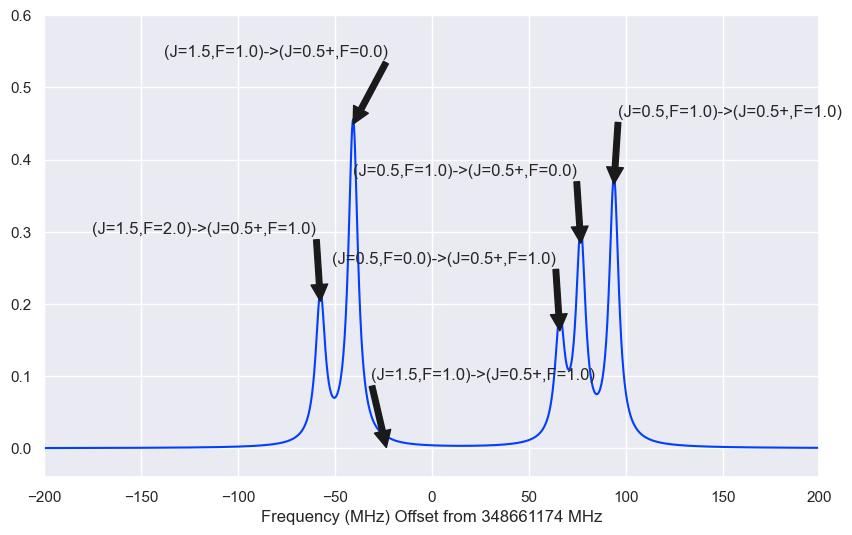

In [64]:
c=29979.2458
origin = e.parameters['Origin']
plt.figure(figsize=(10,6))
MHz = lambda x:c*x-348661174
fMHz = MHz(freq) 
plt.plot(fMHz,tot_lor)

#Wavenumbers of interest
plt.xlim(-200,200)
# plt.axvline(MHz(13284.63682),color='k',linestyle=':')
# plt.axvline(MHz(13284.6366),color='k',linestyle=':')
# plt.axvline(MHz(13284.63573),color='k',linestyle=':')
# plt.axvline(MHz(13284.62854),color='k',linestyle=':')
# plt.axvline(MHz(13284.62832),color='k',linestyle=':')
# plt.axvline(MHz(13284.62676),color='k',linestyle=':')
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency (MHz) Offset from 348661174 MHz')
plt.ylim(-0.04,0.6)

i=0
side = [-3,3,-3,-2,2.5,-3]
lc_lines = []
for tstr,line in zip(t_str_list,flist):
    if 'J=0.5+,' in tstr:
        BR = tstr.split('\n')[-1].split('=')[-1]
        print(i)
        plt.annotate(tstr.split('\n')[0],xy=(MHz(line),float(BR)),ha='center',va='center',xytext=(MHz(line)+20*side[i],float(BR)+0.1),arrowprops={'color':'k'})
        i+=1
        print(tstr.split('\n')[0])
        print(line,'\n')
        lc_lines.append(line)

In [26]:
help(tstr.split)

Help on built-in function split:

split(sep=None, maxsplit=-1) method of builtins.str instance
    Return a list of the substrings in the string, using sep as the separator string.
    
      sep
        The separator used to split the string.
    
        When set to None (the default value), will split on any whitespace
        character (including \n \r \t \f and spaces) and will discard
        empty strings from the result.
      maxsplit
        Maximum number of splits (starting from the left).
        -1 (the default value) means no limit.
    
    Note, str.split() is mainly useful for data that has been intentionally
    delimited.  With natural text that includes punctuation, consider using
    the regular expression module.



In [27]:
lc_MHz = MHz(np.array(sorted(lc_lines)))
lc_MHz-=lc_MHz[0]
lc_MHz= np.delete(lc_MHz,2)
print(lc_MHz)
print(lc_MHz[1:]-lc_MHz[:-1])

[  0.       16.88557 123.56448 134.37042 151.50167]
[ 16.88557 106.67891  10.80594  17.13125]


In [28]:
tstr.split('\n')[1].split('=')[-1]

'0.2333332995519365'

In [29]:
display(Latex(e.gen_state_str(5, thresh=1e-5,label_q=['P','J','F'])))

<IPython.core.display.Latex object>

In [30]:
display(Latex(e.gen_state_str(4, thresh=1e-5,label_q=['P','J','F'])))

<IPython.core.display.Latex object>

In [31]:
for tstr,line in zip(t_str_list,flist):
    if 'J=0.5+,' in tstr:
        print(tstr)
        print(line,'\n')

(J=0.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.38675405976811245
11630.087465922605 

(J=0.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.4985588779175847
11630.088037359488 

(J=0.5,F=0.0)->(J=0.5+,F=1.0)
BR=0.22160304561488486
11630.087105475248 

(J=1.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.6132459420089822
11630.083547049955 

(J=1.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.0014411236654150914
11630.084118486839 

(J=1.5,F=2.0)->(J=0.5+,F=1.0)
BR=0.2783957589578057
11630.082983807803 



In [32]:
leakage = np.array([2.43e-5,3.82e-6,9.16e-7,1.09e-6,4.20e-6,2.58e-5])
d_vals = np.array([-50,-20,-10,10,20,50])

In [33]:
for tstr,line in zip(t_str_list,flist):
    if line>13284.62 and line<13284.65:
        print(tstr)
        print(line,'\n')

In [34]:
0.063+0.063+0.084

0.21000000000000002

In [35]:
41.7226-41.0988

0.6238000000000028

In [36]:
sorted(flist)

[11625.747936843416,
 11625.7642551408,
 11625.76441381959,
 11625.76545119179,
 11626.563966540223,
 11626.5775586955,
 11626.57774301126,
 11626.578776467573,
 11627.37155755256,
 11627.382404670045,
 11627.382633022693,
 11627.383660661213,
 11628.170711384539,
 11628.178761767284,
 11628.179085165273,
 11628.180103203951,
 11628.961447801008,
 11628.966388156543,
 11628.96711957303,
 11628.96811841166,
 11629.49196708034,
 11629.49302187825,
 11629.493043526601,
 11629.509498854424,
 11629.509520502776,
 11629.510536226624,
 11629.510557874975,
 11629.627096255466,
 11629.628137887794,
 11629.628176011976,
 11629.64191435883,
 11629.641952483013,
 11629.642947815144,
 11629.642985939327,
 11629.753756503069,
 11629.754777895156,
 11629.754840995065,
 11629.765853365288,
 11629.765916465198,
 11629.766881003809,
 11629.766944103718,
 11629.87195047349,
 11629.872936637328,
 11629.873042315478,
 11629.881310418063,
 11629.881416096212,
 11629.88232845674,
 11629.88243413489,
 11629.9